# Wasserstein distance

## 1-Wasserstein distance:

\begin{equation}
    W_p(\mu, \upsilon) = \left( \underset{\gamma \in \Gamma(\mu, \upsilon)}{\inf} \int \mathrm d(x, y)^p \mathrm d\gamma(x, y) \right)^{1/p}
\end{equation}

where the $d(x, y)$ is a distance metric between two points $x$ and $y$. $\gamma$ is a coupling of the probability measures $\mu$ and $\upsilon$ (a joint probability distribution that belongs to the set of joint distributions $\Gamma(\mu, \upsilon)$ that have marginals $\mu$ and $\upsilon$).

\begin{align*}
    \mathrm d(x, y)^p&: \text{how far is it from } x \text{ to } y \\
    \mathrm d\gamma(x, y)&: \text{how much mass should we move from } x \text{ to } y
\end{align*}

The $\underset{\gamma}{\inf}$ means to find optimal paths to move the mass from one distribution at $x$ to another one at $y$, then the resulted Wasserstein distance between two distributions is the cost (mass $\times$ distance) under the optimal transport paths.

We consider $\mathrm d(x, y) = | x - y |$ and $p = 1$ for simplicity.

## Kantorovich-Rubinstein duality

\begin{equation}
    \sup_f \int f \mathrm d\mu(x) - \int f \mathrm d\upsilon(y)\qquad \text{where } f: \mathbb R^d \rightarrow \mathbb R\,, \text{Lip}(f) \leq 1
\end{equation}

where $\mu$ and $\upsilon$ are probability measures, and $\text{Lip}(f)$ denotes the Lipschitz constant of the function $f$ (can be a neural network). The Lipschitz contraint can be enforced by weight-clipping, gradient penalty and spectral normalization. The neural network is trained to maximize the $\int f \mathrm d\mu(x) - \int f \mathrm d\upsilon(y)$.

## Wasserstein vs f-divergence

f-divergence assumes two distribution has the same support while Wasserstein doesn't. It means that if two distribution is not overlapping with each other, the f-divergence would become meaningless. The definition of f-divergence is:
\begin{equation}
    D_f(p || q) = \int q(x) f\left( \frac{p(x)}{q(x)} \right) \mathrm d x
\end{equation}


KL-divergence is a special case of f-divergence with $f_{\text{KL}}(t) = t \log t$. The definition of KL-divergence:
\begin{equation}
    D_{\text{KL}}(p || q) = \int p(x) \log \frac{p(x)}{q(x)} \mathrm d x
\end{equation}

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
mix = torch.distributions.Categorical(torch.ones(2,))
comp = torch.distributions.Independent(
    torch.distributions.Normal(
        torch.vstack((-.5 * torch.ones(2,), .5 * torch.ones(2,))),
        0.1 * torch.ones(2, 2)
    ), 1
)
gmm = torch.distributions.MixtureSameFamily(mix, comp)

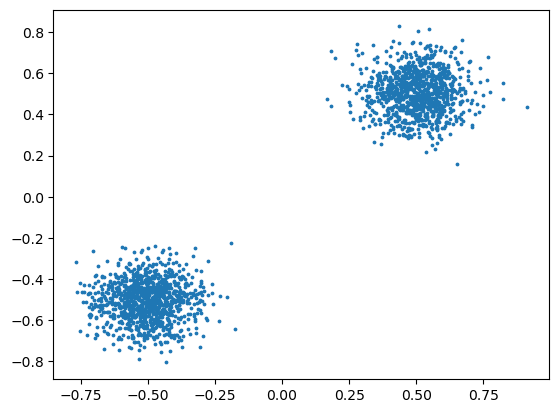

In [3]:
samples = gmm.sample([2048])
plt.scatter(samples[:, 0], samples[:, 1], s=3);

In [4]:
from models import Generator, Discriminator
# from training import gan_training

In [5]:
generator = Generator(input_dim=2, output_dim=2)
discriminator = Discriminator(input_dim=2)
dataloader = torch.utils.data.DataLoader(samples, batch_size=64, shuffle=True, pin_memory=True)

discriminator loss: -0.042300 generator loss: -0.110459  [    0/  150]


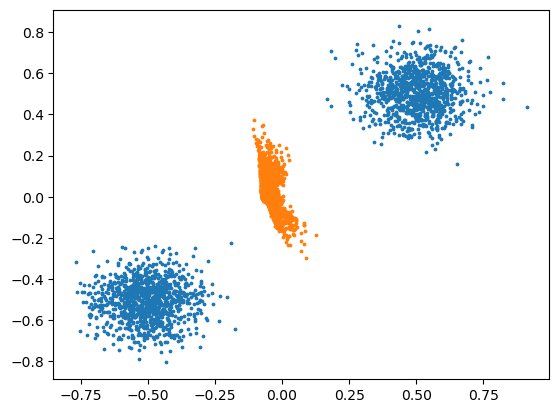

discriminator loss: -0.038503 generator loss: 0.004004  [   15/  150]


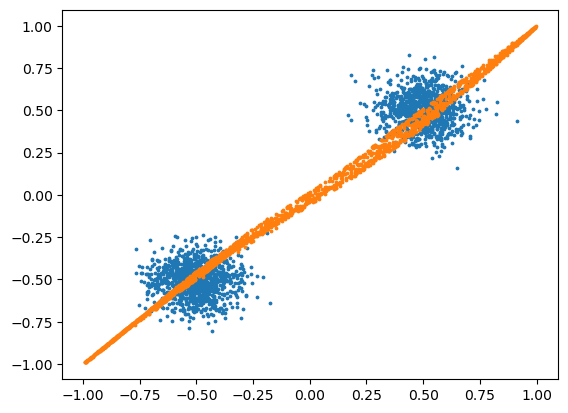

discriminator loss: -0.033835 generator loss: -0.262247  [   30/  150]


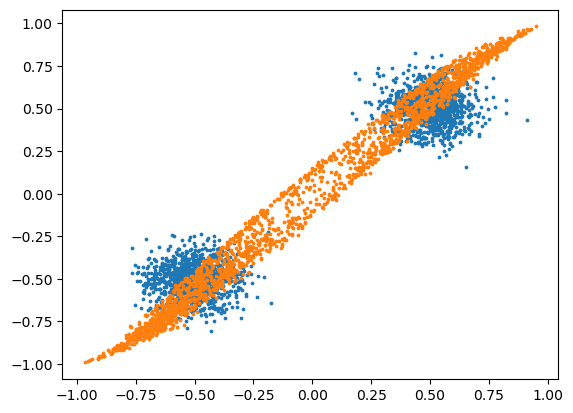

discriminator loss: -0.033573 generator loss: -0.205826  [   45/  150]


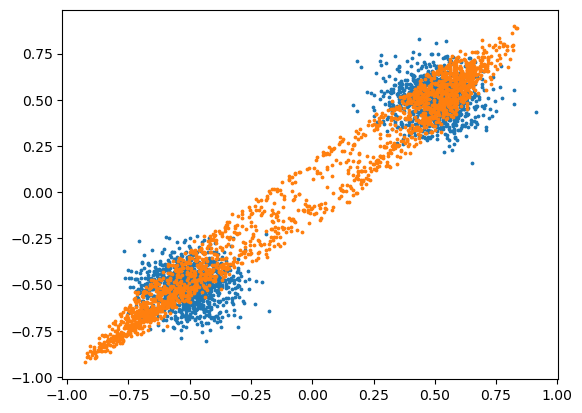

discriminator loss: -0.030183 generator loss: -0.319958  [   60/  150]


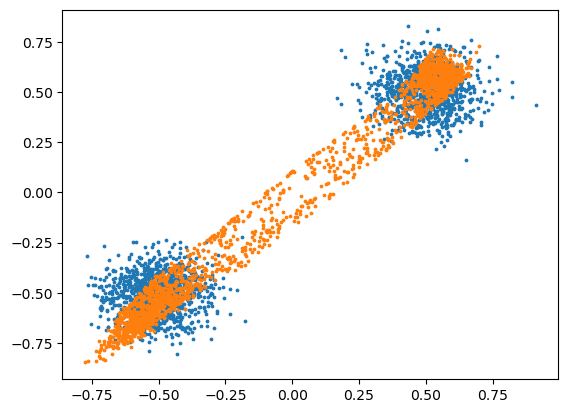

discriminator loss: -0.018755 generator loss: -0.418776  [   75/  150]


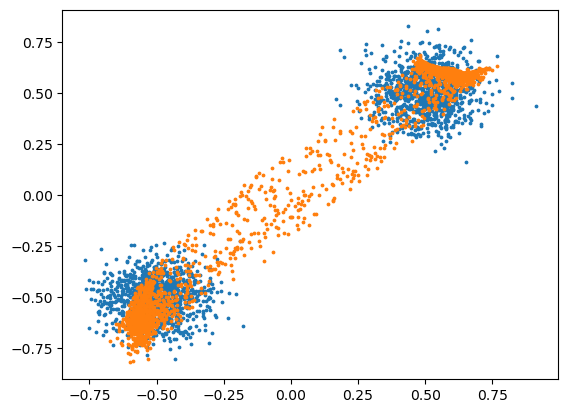

discriminator loss: -0.016055 generator loss: -0.341308  [   90/  150]


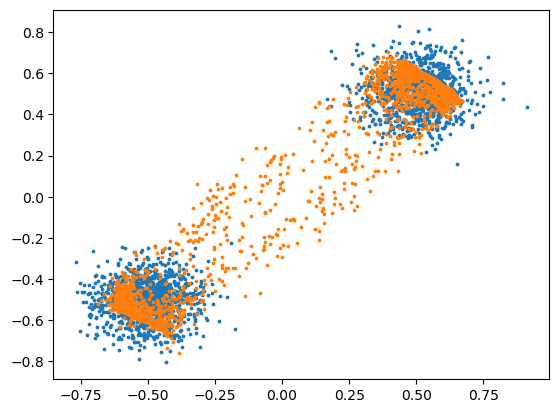

discriminator loss: -0.029381 generator loss: -0.360207  [  105/  150]


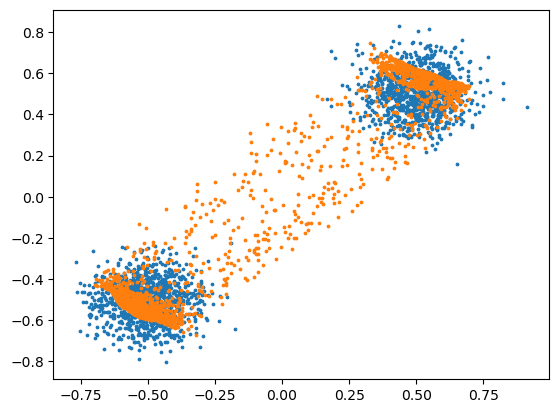

discriminator loss: -0.017812 generator loss: -0.224447  [  120/  150]


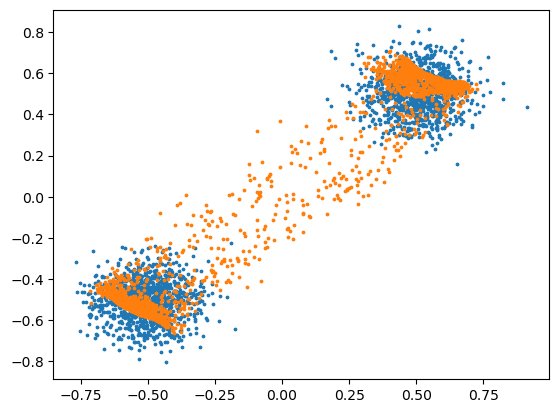

discriminator loss: -0.005391 generator loss: -0.474436  [  135/  150]


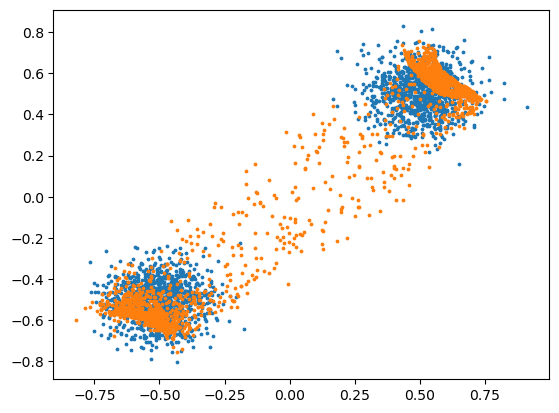

In [6]:
num_epochs = 150
device = 'cpu'
num_critic = 5

discriminator.train()
generator.train()

# Optimizers
optimizer_g = torch.optim.Adam(
    generator.parameters(), lr=1e-4, betas=(0.5, 0.999)
    # , weight_decay=1e-4
)
optimizer_d = torch.optim.Adam(
    discriminator.parameters(), lr=4e-4, betas=(0.5, 0.999)
    # , weight_decay=1e-4
)

for epoch in range(num_epochs):
    for i, data_real in enumerate(dataloader, 0):

        # Train with all real data
        # update discriminator network: maximize E(log(D(x))) + E(log(1 - D(G(z))))
        optimizer_d.zero_grad()

        # update generator: maximize log(D(G(z)))
        data_real = data_real.to(device)
        z = torch.randn(dataloader.batch_size, generator.input_dim)
        with torch.no_grad():
            data_fake = generator(z)

        outputs_real = discriminator(data_real)
        outputs_fake = discriminator(data_fake)

        d_loss = - torch.mean(outputs_real) + torch.mean(outputs_fake)
        d_loss.backward()
        optimizer_d.step()

        if i % num_critic == 0:
            # Train generator
            optimizer_g.zero_grad()

            data_fake = generator(z)
            g_loss = - torch.mean(discriminator(data_fake))
            g_loss.backward()
            optimizer_g.step()

    if epoch % 15 == 0:
        print(f"discriminator loss: {d_loss.item():>7f} generator loss: {g_loss.item():>7f}  [{epoch:>5d}/{num_epochs:>5d}]")
        z = torch.randn(2048, generator.input_dim)
        with torch.no_grad():
            data_fake = generator(z)
        plt.scatter(samples[:, 0], samples[:, 1], s=3)
        plt.scatter(data_fake[:, 0], data_fake[:, 1], s=3);
        plt.show()

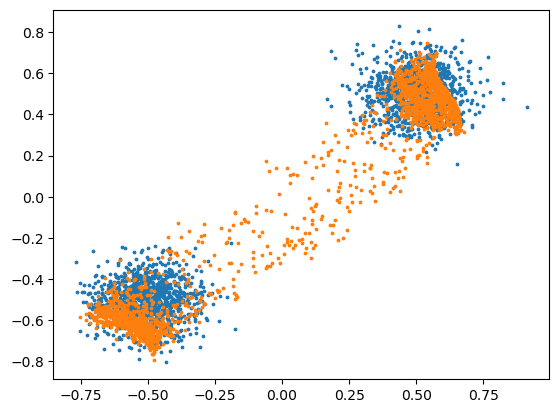

In [7]:
z = torch.randn(2048, generator.input_dim)
with torch.no_grad():
    data_fake = generator(z)
plt.scatter(samples[:, 0], samples[:, 1], s=3)
plt.scatter(data_fake[:, 0], data_fake[:, 1], s=3);
plt.show()